In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'


In [2]:
import numpy as np
import scipy.optimize as opt
import emcee, corner
from multiprocessing import Pool

from likelihoods import likelihood
import bin_range

In [3]:
print("Active z-bin:", bin_range.zmin, "to", bin_range.zmax)

Active z-bin: 0.01 to 2.33


In [4]:
chi2_fn, param_names = likelihood.build_total_chi2()

print("Parameter order:")
print(param_names)

ndim = len(param_names)

Parameter order:
['Ob0', 'H0', 'As', 'alpha', 'M', 'rd']


# 2. Priors and log-posteriors

In [5]:
bounds = {
    "Ob0"  : (0.03, 0.06),
    "H0"   : (0, 100),
    "As"   : (0.0, 1.0),
    "alpha": (0.0, 0.3),
    "M"    : (-25, 25),
    "rd"   : (100, 200.0), 
}


def lnprior(theta):
    for name, value in zip(param_names, theta):
        lo, hi = bounds[name]
        if not (lo < value < hi):
            return -np.inf
    return 0.0


def lnposterior(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf

    chi2 = chi2_fn(theta)
    val = -0.5 * chi2 + lp

    if np.isnan(val):
        return -np.inf
    return val


# 3. Initial walkers

In [ ]:
seed_dict = {
    "Ob0":   0.049,
    "H0":    70.0,
    "As":    0.8,
    "alpha": 0.0,
    "M":     0.0,
    "rd":    144.0,  
}

def assemble_vector_from_names(names, values_dict):
    return np.array([values_dict[n] for n in names], dtype=float)

theta0 = assemble_vector_from_names(param_names, seed_dict)
print(theta0) #theta0 es el punto fiducial en el espacio n-dimensional, semilla, punto inicial

[4.90e-02 7.00e+01 8.00e-01 2.00e-01 0.00e+00 1.44e+02]


# 4. Run MCMC

In [ ]:
nwalkers = max(2 * ndim + 2, 30)
proposal_scales = {
    "Ob0":   0.001,
    "H0":    1.5,
    "As":    0.02,
    "alpha": 0.01,
    "M":     0.1,
    "rd":    10.0,
}

scales = np.array([proposal_scales[n] for n in param_names])

rng = np.random.default_rng(1234)
p0 = theta0 + rng.normal(scale=scales, size=(nwalkers, ndim)) # Primer desplazamiento respecto al
                                                              # punto fiducial


In [8]:
nsteps = 8000   # ajusta según necesidad

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnposterior, pool=pool
    )
    sampler.run_mcmc(p0, nsteps, progress=True)


100%|██████████| 8000/8000 [02:36<00:00, 51.22it/s]


# Convergence diagnostics 

In [9]:
try:
    tau = sampler.get_autocorr_time()
    discard = int(nsteps / 3)
    thin = max(1, int(np.min(tau) / 2))
    print("Autocorrelation time:", tau)
except Exception as e:
    print("Autocorr failed:", e)
    discard = int(nsteps / 5)
    thin = 1


Autocorrelation time: [143.31746528 145.26718644 114.54253401 124.162321   121.67021672
 144.39132698]


In [10]:
flat_samples = sampler.get_chain(
    discard=discard, thin=thin, flat=True
)


# Cornert Plot

In [11]:
# labels = param_names
# labels = [r'$\Omega_{b}$', r'$H_0$', r'$A_s$', r'$\alpha$', r'$M$', r'$r_d$']


# fig = corner.corner(
#     flat_samples,
#     labels=labels,
#     show_titles=True,
#     plot_contours=True,
#     smooth=True
# )

# fig.savefig("corner.pdf", bbox_inches="tight")


Removed no burn in


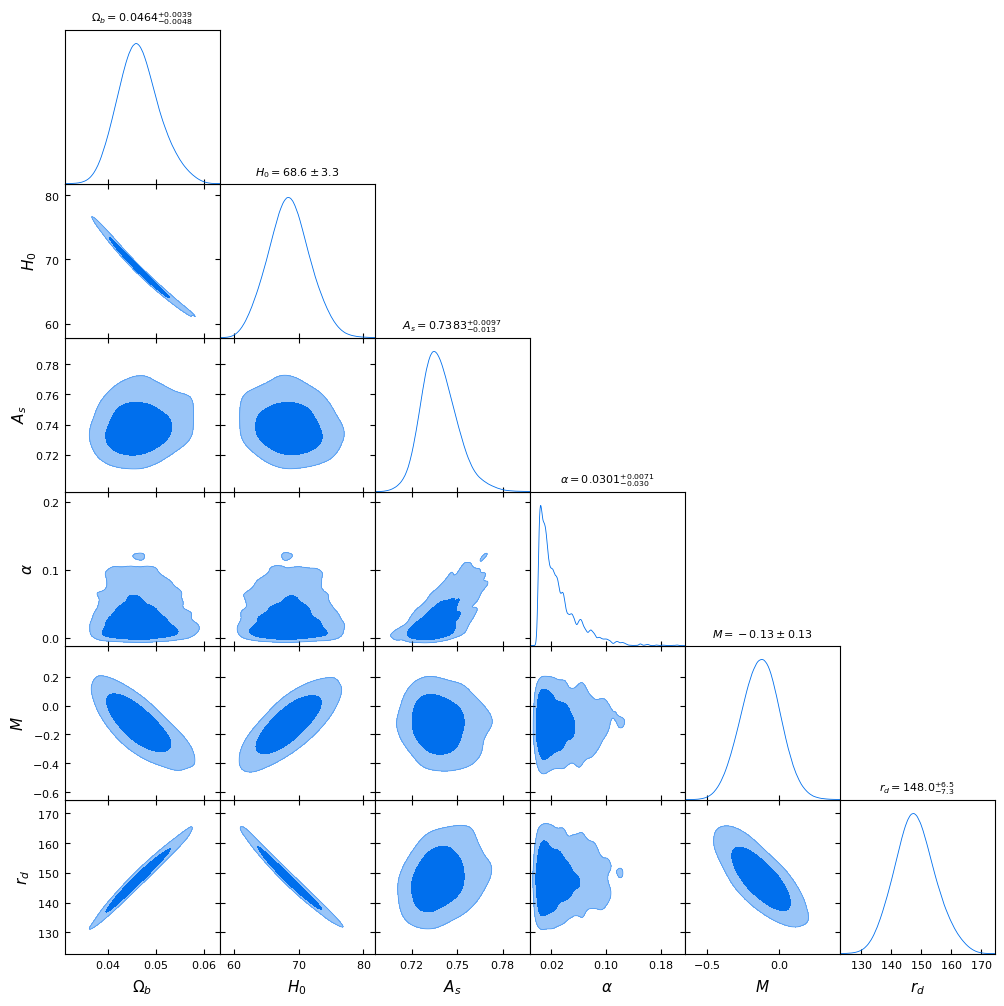

In [12]:
from getdist import MCSamples
import getdist.plots as gdplot

labels = [r'\Omega_{b}', r'H_0', r'A_s', r'\alpha', r'M', r'r_d']

g1 = MCSamples(
    samples = flat_samples,
    names   = param_names,
    labels  = labels,
    label   = "Data"
)


g = gdplot.getSubplotPlotter()

g.settings.title_limit = 1
g.settings.title_limit_labels = True
g.settings.num_plot_contours = 2


g.triangle_plot([g1], filled=True)
g.export("corner.pdf")

